# Normalized Pick Rate
## (A Modeling Diary)

Normalized Pick Rate, or **NPR**, is a new metric I've developed to reflect the inferred pick orders of top players from the daily card data available on 17Lands, specifically ALSA, # Seen, and # Picked. NPR estimates the pick rate of the card at P1P1 and is measured on a logarithmic scale. The normalization is such that a value of 0.0 represents even odds to be chosen P1P1 (i.e. 13:1 against), and each increment represents a doubling of those odds, so that a value of 1.0 gives 13:2 odds and a 10.0 gives 13:1024 odds, or about a 99% probability of being chosen from a given pack. A -8.0, typical of a basic land, represents 3328:1 odds of being chosen, effectively nil. That doesn't mean that basic lands were actually chosen once out of every 3329 P1P1, it's just a consequence of the statistical modeling which doesn't fully capture edge-case behavior. Here's an example from MH3. Fair warning, this is going to be one where I share lots of code.

In [2]:
import polars as pl
from great_tables import GT

from spells import summon # my package for aggregating 17Lands public data
from deq import ext # the official definition of NPR is in here

df = summon(
    "MH3",
    ["npr"],
    filter_spec={'$and': [{'player_cohort': 'Top'}, {'lhs': 'format_day', 'op': '>', 'rhs': 7}]},
    extensions=ext
).filter(pl.col('name').is_in([
    'Guide of Souls', 
    'Writhing Chrysalis', 
    'Eldrazi Repurposer', 
    'Twisted Riddlekeeper', 
    'Hydra Trainer', 
    'Swamp'
])).sort('npr', descending=True)

GT(df.rename({'name': 'Name', 'npr': 'NPR'})).fmt_number('NPR').tab_header('Normalized Pick Rate')

GT(_tbl_data=shape: (6, 2)
┌──────────────────────┬───────────┐
│ Name                 ┆ NPR       │
│ ---                  ┆ ---       │
│ str                  ┆ f64       │
╞══════════════════════╪═══════════╡
│ Guide of Souls       ┆ 8.370209  │
│ Writhing Chrysalis   ┆ 5.084362  │
│ Eldrazi Repurposer   ┆ 1.802911  │
│ Twisted Riddlekeeper ┆ -0.09779  │
│ Hydra Trainer        ┆ -3.923923 │
│ Swamp                ┆ -8.847253 │
└──────────────────────┴───────────┘, _body=<great_tables._gt_data.Body object at 0x7fe3ad6bf690>, _boxhead=Boxhead([ColInfo(var='Name', type=<ColInfoTypeEnum.default: 1>, column_label='Name', column_align='left', column_width=None), ColInfo(var='NPR', type=<ColInfoTypeEnum.default: 1>, column_label='NPR', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7fe361d68310>, _spanners=Spanners([]), _heading=Heading(title='Normalized Pick Rate', subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7fe32cecf090>, _formats=[<great_tables._gt_data.FormatInfo object at 0x7fe32cecebd0>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_left_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), heading_background_color=OptionsInfo(scss=True, category='heading', type='value', value=None), heading_align=Options

My hope is that whenever you are struck wondering how top players are prioritizing different cards early, you will drop by [DEq](https://magic-flea.com/on-draft/deq.html) to check the NPR stat. I still recommend using the DEq metric itself to make early picks, although this approach is viable as well (as we'll see) and you might benefit from using it to break near ties. 

I don't have much else to say of interest from a Magic point of view, but I'd like to document the model. Since I can do whatever I want, I thought I would take this opportunity to walk you all through the process of creating of a new metric, including the details of how I put my code together. Hopefully it can provide some inspiration for those of you training to enter a quantitative field, or a new point of view for other professionals. Ultimately we will get into advanced-undergraduate territory, but I hope there's something to learn for those at earlier stages of their journey. If all you're interested in is getting some useful stats to pick Magic cards, this is your cue to jump back in the queue.

## Inspiration

If you haven't seen Dan Brooks's [Statistical Drafting](https://statisticaldrafting.com/) I hope you'll check it out, it's an amazing resource, a fantastic application of a neural net architecture to Magic drafting, and a wonderful interactive quantitative presentation. While I was excited to see the work in general, I was also excited because I have been waiting for someone to produce competing quantitative pick orders for me to test against DEq using my [substitution analysis](p1-strategy). These are totally independent pieces of analysis, so there's no reason the results would be biased in favor of DEq and there's every reason to hope that the best metric may "win". I'll recompile the data now to make sure I have his latest numbers and run it again. I'll show the broad expected win rate change as well as the entropy graph, which I'll explain. I'll use the abbreviation "SD" to refer to the Statistical Drafting model below.

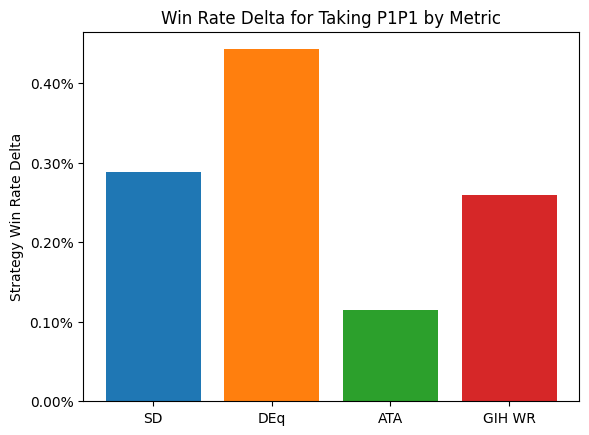

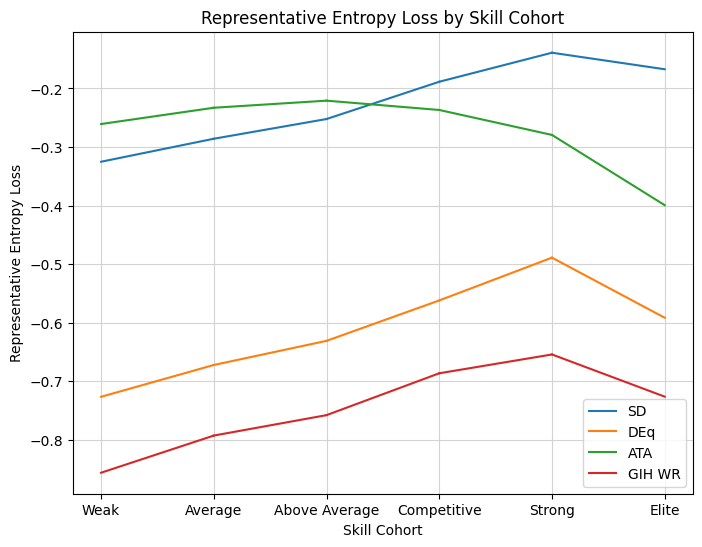

In [9]:
import os
from deq.p1_strategy import all_metrics_analysis
from deq.plot import p1_delta_bar, p1_line_plot

sets = ["EOE", "FIN", "TDM", "DFT"]
metrics = ["danb", "deq", "pick_equity", "gih_wr_17l"] # pick equity is a stand-in for ATA where higher is better
metric_context = pl.concat([
    pl.read_csv(
        os.path.expanduser(f"~/imports/danb-{set_code.lower()}.csv")
    ).with_columns(pl.lit(set_code).alias('expansion'))
    for set_code in sets
])
# equivalent to the data used by SD
metric_filter = {
    '$and': [
        {'player_cohort': 'Top'}, {'lhs': 'format_day', 'op': '>', 'rhs': 2}
    ]
}
results_filter = {'lhs': 'format_day', 'op': '>', 'rhs': 3} 
labels = {'danb': 'SD'}

result = all_metrics_analysis(
    sets=sets, 
    metrics=metrics, 
    results_filter=results_filter,
    metric_filter=metric_filter,
    metric_context=metric_context,
)

p1_delta_bar(result, metrics=metrics, metric_labels=labels)
p1_line_plot(result, mode="entropy_loss", metrics=metrics,  metric_labels=labels)

I find this to be a beautiful result that shows how analysis can uncover hidden structure. Without knowing anything about Dan's methodology, we can start to put together a picture of what SD is doing and how effective it is. First, let's look at the win-rate results. According to the chart, on average, players would gain about 0.28% of game win rate in PremierDraft by following SD P1P1 rankings instead of what they would normally do, then drafting as usual from that point. Now, SD is a complete draft bot, not just a P1P1 ranking, but this is all I'm able to analyze by looking at results after the fact. While the SD rankings don't quite compete with DEq, they do lead to stronger results on average than GIH WR. Given that GIH WR is the community standard for card quality, and that most people would be better off using it more, I think it points to a fundamental efficacy of the model. 

The second chart is what really got me thinking. The chart depicts the information loss using the implied P1P1 rankings instead of the observed distribution. As an example, suppose that a given ranking always prioritized commons P1P1. That means that all of the draft data from players who chose mythics, rares, and uncommons would be unusable, and we would need to infer win rates from a much smaller sample. That loss of information is what the "Representative Entropy Loss" graph captures, separated out by the player skill estimate, since entropy is a measurement of information. We immediately see that SD is doing something special here. It is capturing the preferences of Strong and Elite drafters better than ATA, even though ATA is itself measuring the preferences of top drafters (all of the statistics here use an in-sample approximation of the "top" player cohort found on 17Lands). My immediate conclusions from the chart is that the training of SD is specifically trying to capture the preferences of top drafters, which I confirmed with Dan.

The point I wasn't prepared for was the viability of such a strategy. I had been using ATA as a shorthand for player preference in my analysis, and since following the metric is not particularly viable compared to even GIH WR, I hadn't done much follow-up analysis. But now we are seeing that a metric trained on the actual preferences of top drafters is viable, and those preferences are significantly different from what ATA expresses. Why is that?

Well, I knew the answer. Any one who listens to Sierkowitz knows that ATA is not really measuring preferences, and given it's distorted view of rankings, you are often better off using ALSA as an impression of the overall availability of cards. Now I was aware of this, and use ATA in DEq because it measures what I need to measure — the opportunity cost paid by the actual drafters whose win rates we measure. Using it as a pick order proxy was simply convenience. I had the ranking at my fingertips, and showing the contrast of GP WR and ATA to the metric combination, DEq, demonstrated the power of combining them.

As the "extract new information from daily card data" guy, my mind immediately got spinning on whether we could infer this kind of priority from the available data on 17Lands. Let's remember why ATA doesn't actually measure preferences. For cards that are highly prioritized by average players, but not by top players, those cards disappear from packs before they are able to be chosen, so the only time they are chosen are early. This implies that, for a given rarity, the cards players actually want will end up in their pile more often than the ones that simply disappear. My first idea was to look at those pick counts and normalize by rarity, and combine that information with ATA statistically.

But this is where the real skill, maybe the only skill, of quantitative problem solving comes in. You get a feeling, from experience, that your solution is not the best solution, and, if the best solution is not apparent, you spend a few days turning it over in your mind. Something about using rarity felt wrong and wouldn't work anyway, given the uncertain structure of modern packs. Surely there is a way to extract that information in a cleaner way from the available data. Now, the answer is probably obvious since it's in the title, or because you listen to Sierko even closer than I do, but for whatever reason it took me a few days. The question just sort of sat in my head, and I would turn it over in the odd hours. That's how you solve a problem. Pick rate, of course. Cards taken divided by cards seen. Both counts are available on 17Lands, even for the smallest sample sizes, and that should be enough to differentiate players' preference for cards with the same ATA. But how do you differentiate cards with different ATA and different pick rates? We need a model.

The next step is to extract and analyze that pick rate data, and model its relationship to ATA understand what we are trying to extract. The basic idea is this: for a given card, with a given fixed preference by the cohort, for each later pack that card appears in, the higher its pick rate will be, since the quality it's competing against declines. Therefore a card with lower ATA but equivalent preference to another card should have a lower overall pick rate because it was not available in those later packs for its pick rate to increase. I start to conceive of ways to observe that trend, but first I'd like to know I'm on the right track. Let's take a look at what kind of card quality information is encoded in the pick rate itself, using our tried-and-true approach above.

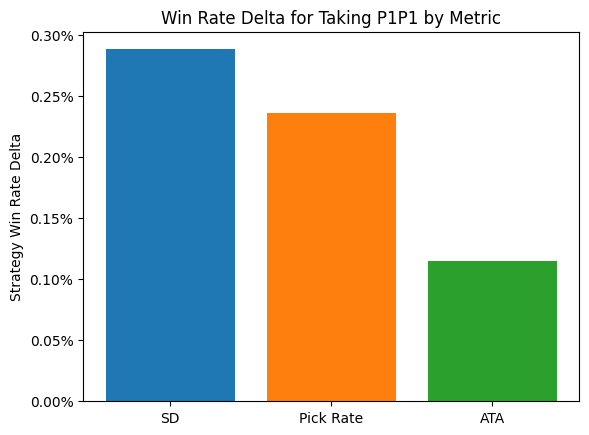

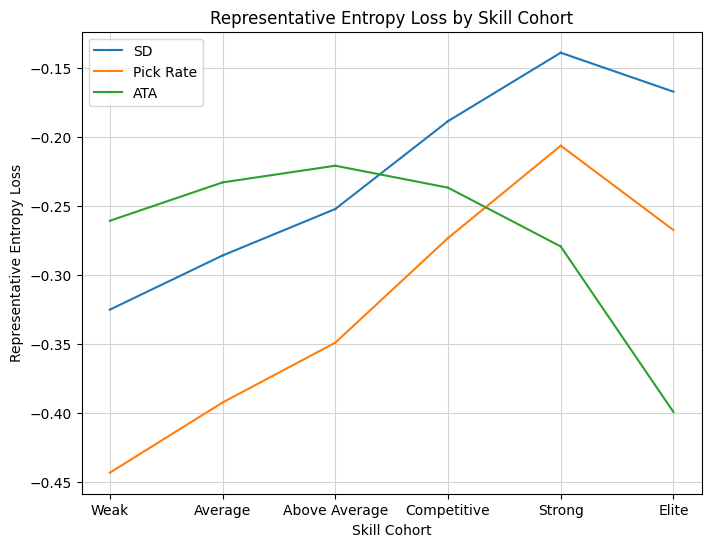

In [14]:
ext = {
    'pick_rate': agg_col(pl.col('num_taken') / pl.col('num_seen'))
}
labels = {**labels, 'pick_rate': 'Pick Rate'}
metrics = ['danb', 'pick_rate', 'pick_equity']

result = all_metrics_analysis(
    sets=sets,
    metrics=metrics, 
    results_filter=results_filter,
    metric_filter=metric_filter,
    metric_context=metric_context,
    extra_ext=ext
)

p1_delta_bar(result, metrics=metrics, metric_labels=labels)
p1_line_plot(result, mode="entropy_loss", metrics=metrics,  metric_labels=labels)

Another wonderful result! Pick rate is perfect, it's exactly the metric we need to represent the missing information about preferences. It's more viable than ATA as a method for picking cards, and the shape of the entropy curve perfectly matches the one for SD. We have every reason to hope that some additional modeling of the relationship between pick rate and ATA will get us very close to true preference rankings. Now we need an idea for how to do that, but fortunately I can build off an analysis I've been turning to for a long time — the pick-by-pick charts. Normally I graph how as-picked win rate changes with pick location, but in this case, for a given card, I can graph pick rate against pick number and I should see that theoretical increase. Before we do that, it will be better to understand a better model for pick rate than pure probabilities. Probabilities are not practical for modeling preferences directly. For one thing, they are bounded below and above by zero and one, respectively, and bounds can be inconvenient to deal with in statistical estimation. Furthermore, there are important differences that we need to be able to distinguish near a boundary. An A- rare might be chosen out of most packs, but when it happens to appear opposite an A+, we want to clearly distinguish those cases. We might even hope for some representation that can model preferences in a stable way across packs.

## Urns and Logits
Let's construct a tractable model for preference. Suppose we have a card $c$ and we want to assign it a value that represents its chance of being taken out of any particular pack — a weight $w_c$. Then for a pack with cards $c_j$ for $j = 1,...,k$, with some $c_j = c$ and weights $w_{c_j}$, we say the probability $c$ is chosen is 

$$
p_c = \frac{w_c}{\sum_j^k w_j}.
$$

This is an assumption, a simple model analogous to a uniform distribution that allows us to represent varying levels of preference. It reflects an urn model with $w_c$ copies of card $c$ in any selection round against any other set of cards, although in our case $w_c$ need not be a whole number. If $w_c$ is very large relative to the other choices, $p_c$ is close to 1, and if it is very small (close to zero), $p_c$ is close to zero, assuming the other weights are larger. When $c$ is the only card in the pack, we have simply $p_c = w_c/w_c = 1$ regardless of $w_c$, which is good because that's how draft works as well.


This simple model gives us the power to express the full scale of card preference from trash commons to mythic bombs. The model asserts that preference is a one-dimensional determinant of choice, which is contrary to how a real drafter might consider things like wheel potential and signals sent, but it will do for our purposes. Our next task is to consider how to estimate $w_c$.

An important step is to separate the effects of the other variables on $w$. We apply a logarithm to move into arithmetic space:

$$
\begin{align}
\log(p_c) &= \log\left(\frac{w_c}{\sum_j^k w_j}\right)\\
&= \log(w_c) - \log\left(\sum_j^k w_j\right).
\end{align}
$$

This quantity $\log(w_c)$ is so important that we work with it directly, letting $\theta_c = \log(w_c)$, so that the probability expression, or "log likelihood" for one pack, becomes 

$$
l_c = \theta_c - \log\left(\sum_j^k e^{\theta_j}\right).
$$

The term likelihood is used rather than probability when considering different models for the same event rather than vice versa. This is called a "softmax" model for those of you who may know the models but not the mathematical motivation behind them, and all of the derivations below are for variations on softmax, in case you'd like to search up additional reading. Suppose the cards besides $c$ have collective fixed weight $A$, and solve

$$
p = \frac{e^{\theta}}{A + e^{\theta}},
$$
for $\theta$, getting 

$$
\theta = \log\left(\frac{Ap}{1-p}\right) = \log\left(\frac{p}{1-p}\right) + \log A.
$$
The first expression is the standard sigmoid function, and the ratio $p/(1-p)$ is known as the "odds", as it exactly corresponds to the quantity used in odds-making. If you haven't seen this before, it's a great way to motivate the standard sigmoid function.
 
When comparing cards to each other with equivalent context, the added quantity $\log A$ is effectively arbitrary (as we'll see), so the quantity $\theta$ is often known as the "log odds", and in our situation the relative odds of two alternatives are determined by comparing their weights: the odds of card $c_a$ heads up vs $c_b$ can be expressed as $e^{\theta_a} : e^{\theta_b}.$ Since odds are compared as ratios, log odds are compared as differences. In other words, a card with log odds one greater than another is a factor of $e$ more likely to be chosen from any given pack. We use the natural logarithm for calculations, but in the final metric it will be a simple matter to rescale to use base two, giving the interpretive scheme at the top of this article.

Since the shift is arbitrary, we will choose a baseline such that $\theta = 0$ at even odds to be chosen P1P1. Assumptions aside, this is good enough motivation to begin looking at the relationship between pick rate and pick number. Pick rate will directly estimate $p$, and the logit transformation gives us a way to get a handle on the full range of values ("logits" is a synonym for "log-odds" that is the standard way to express the scale). We will calculate the "pick rate logits" and plot against pick number for each card. We'll also restrict to pack one to focus on the inference of P1P1 value, and pick out some cards with a range of pick orders.


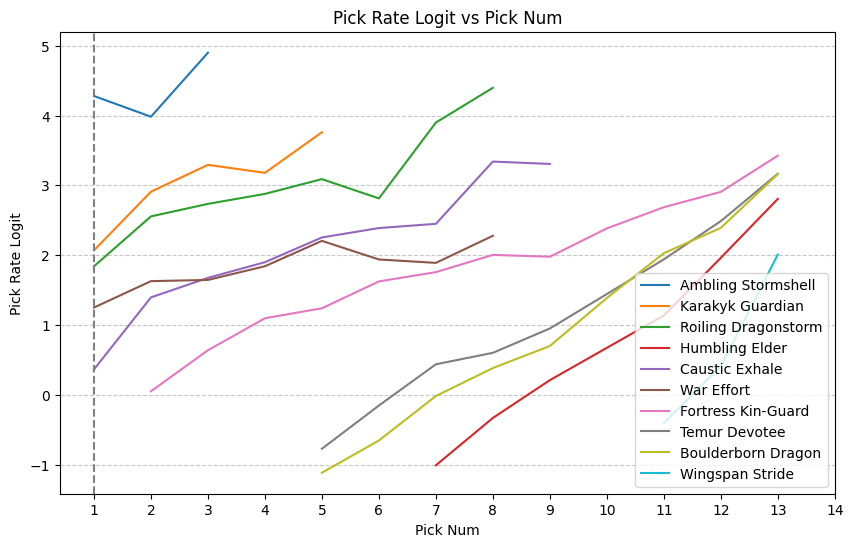

In [188]:
import matplotlib.pyplot as plt
from deq.plot import line_plot

ext = {
    **ext,
    'pick_rate': agg_col(pl.col('num_taken') / pl.col('pack_card')),
    'pick_rate_logits': agg_col((pl.col('pick_rate') / (1 - pl.col('pick_rate'))).log() - pl.lit(1.0 / 13.0).log())
}

pack_one_filter = {'$and': [metric_filter, {'pack_num': 1}]}

names = [ 
    'Ambling Stormshell',
    'Karakyk Guardian',
    'Roiling Dragonstorm',
    'Humbling Elder', 
    'Caustic Exhale',
    'War Effort',
    'Fortress Kin-Guard',
    'Temur Devotee',
    'Boulderborn Dragon', 
    'Wingspan Stride'
] 

df = summon(
    "TDM",
    columns=["pick_rate_logits", "num_taken"],
    group_by=["name", "pick_num"],
    filter_spec=pack_one_filter,
    extensions=ext
).filter(
    pl.col('num_taken') > 20
).pivot(
    on="name", index="pick_num", values="pick_rate_logits"
).sort("pick_num").select(pl.col('pick_num').alias('Pick Num'), *names)

ax = line_plot(df, title="Pick Rate Logit vs Pick Num", y_label="Pick Rate Logit", return_ax=True)
ax.axvline(x=1, color="grey", linestyle="--")
plt.show()

Our hopes for this chart were well-founded. The logit transformation nicely spaces out the pick rates, and we see the expected increase in slope as pick number increases. In fact, aside from War Effort, the shape of the plots almost seem to imply a perfect gradient field, which would be ideal for inferring preferences. How would those underlying preferences manifest in the plot? Remember that under the assumption that the remaining cards in the pack have total preference independent of the given card, we can use the pick rate logit as the estimator. That assumption will be most nearly true in P1P1, so we'd roughly like to trace the lines out to the intercept at pick one and read off the ratings. By the way, we expected an increase, but was it reasonable to expect a linear relationship? Just a bit of additional modeling can tease out the implied assumption there. Suppose that the logit function has the following form:

$$
\log\left(\frac{p_j}{1-p_j}\right) = j\theta + cj,
$$

then reversing our previous derivations shows that 

$$
\begin{align}
\frac{p_j}{1-p_j} &= e^\theta e^{cj} \\
p_j(1 + e^\theta e^{cj}) &= e^\theta e^{cj} \\
p_j &= \frac{e^\theta}{e^{-cj} + e^\theta} \\
\end{align}
$$
So linear growth in the pick rate by pick would represent an exponential decay in the quality of the remaining cards. That corresponds to the case where the chosen card represents roughly a fixed fraction of the overall power remaining in the pack, which is a reasonable starting point. Certainly we could calculate the slope of best fit with a weighted average of the slopes in the charts for the individual cards, interpolate from the $(\text{ATA}, \text{Pick Rate Logit})$ point to $x=1$, and call it a day.

That said, if we want to be as precise as possible in our inference, there are a few difficulties that present themselves. First of all, we should be using ALSA, not ATA. ALSA has denser data and corresponds to the mean of the denominator of the pick rate, which should be more stable. Now for the issues — for one thing, rarity continues to throw a wrench in things. For commons, the remaining cards have a higher power level than is the case for rares, since there is an extra rare in the pack. Additionally, the shape isn't quite linear, especially right at $x=1$, there seems to be a kink downward and there is a steeper slope for later-pick cards. But the biggest problem is something you might have noticed in the code — the "Num Seen" stat from 17Lands does not double-count cards that wheel, which is what you need to do to properly measure the pick rate. A card that wheeled and then was taken was only taken half the time it was seen, but the "seen" pick rate according to 17Lands is 100%. We can still use the metric, but the effect on later-picked cards will be skewed. I decided I wasn't satisfied with things as they stood, and it was time to bring out bigger guns.

## Maximum Likelihood Estimation

Rather than try to guess at a vague intercept, let's directly estimate the preference parameter $\theta_c$ for each card, and then find an appropriate model in our two parameters ALSA and Pick Rate. As a side effect we will implement something sophisticated, mathematically beautiful, and potentially 
useful. I won't give a blow-by-blow of the derivation and development of the estimator for $\theta$. It's something I'd like to do down the road, as there are many interesting applications to limited Magic, but we are in too deep as it is. Let me briefly give you the model, because I think there are some of you out there like me who have wrestled with this simply on a notational level and might find this useful. Suppose we have packs $i = 1, ..., n$, all cards enumerated $j = 1, ..., m$, then let $\delta_i, j = 1$ if card $j$ appeared in pack $i$ and $0$ otherwise, and let $\epsilon_{i, j} = 1$ if card $j$ was chosen in pack $i$ and $0$ otherwise. Then the likelihood of all observations is the product over all observed packs is 

$$
L(\theta) = \prod_{i}^n \frac{\sum_j^m \epsilon_{i, j} e^{\theta_j}}{\sum_j^m \delta_{i, j} e^{\theta_j}}.
$$

This is a useful form for users of the 17Lands public data because the variables correspond exactly the data available. We will streamline things notationally with vector representations of $\mathbf{\epsilon_i} = (\epsilon_{i, 1}, ..., \epsilon_{i, m})$, with $\mathbf{\delta_i}$ and $\mathbf{\theta}$ defined as $m$-dimensional vectors similarly. Take the log and the log likelihood $l$ is given by 

$$
l = \sum_i^n \mathbf{\epsilon_i} ^T \mathbf{\theta} - \log\left( \mathbf{\delta_i}^T e^\mathbf{\theta} \right),
$$

where the $^T$ symbol represents matrix multiplication by a transpose column vector, i.e. the dot product. We get to pull the sum through the log in the left term because OM1 doesn't exist and you take one card per pack in Magic. This is the quantity we want to maximize, and it should be nicely convex, so the plan is to take two derivatives and use Newton's method. The solution will be known as the maximum likelihood estimation, or MLE. I'll give those forumulas for the real nerds out there and skip the implementation (for now). First, the gradient,

$$
\nabla l = \sum_i^n \mathbf{\epsilon_i} - \frac{\mathbf{\delta_i} e^\mathbf{\theta}}{Z},
$$

where $Z$ is the partition function (total pack weight) $\delta_i ^T e^{\mathbf{\theta}}$, and the elementwise multiplication $\mathbf{\delta}_i e^{\mathbf{\theta}}$ is the weight vector, which means $ \mathbf{p_i} = \mathbf{\delta_i} e^\mathbf{\theta}Z^{-1}$ is the vector of probabilities of each card being chosen in pack $i$. That gives the elegant form


$$
\nabla l = \sum_i^n \mathbf{\epsilon_i} - \mathbf{p_i}.
$$

The gradient is the vector direction we would like to move to increase the likelihood expressed by the model, using the analogy of climbing a mountain by pointing your feet in the steepest direction. I wanted to get to this point because it's formulas like this that illustrate the power and clarity that mathematical analysis can bring. Let me explain. The expression is the sum of vector differences $\mathbf{\epsilon} - \mathbf{p}$, one for each pack. Suppose that there is only one pack in the sample. Then the gradient is zero when $\epsilon = \mathbf{p}$, that is, when the probability of choosing the chosen card is 1 and all other probabilities are zero. In general, for the card chosen in a given pack $c$, the gradient contribution is $1-p_c$, which is positive, meaning it contributes towards increasing the value of $\theta_c$ proportional to the expectation that it wouldn't be chosen, and for all other cards in the pack, the gradient contribution is $-p_c$, meaning they contribute negatively proportional to the expectation that they would have been chosen. Thus in one tiny expression, we see encoded all of the necessary information to optimize $\mathbf{\theta}$.

Simple formulas like this are very often at the heart of what we call "the algorithm." Rather than solve large optimization problems, services will record choices with simple vectors like this and use them to update a global or personalized parameter set in a totally distributed way. The parameters often will represent the likelihood that you're expected to click on a given widget, exactly analogous to a draft. As an exercise, develop a model to order a feed of YouTube thumbnails! The scheme is so simple that you might think of it without any analysis at all, but the fact that it relates back to a macro likelihood model means we can bring additional analysis to bear to optimize the training rate, calculate loss functions, and ensure stability.

In our case, we are looking for a batch optimization, and to apply Newton's method we will need the Hessian matrix, the second derivative of the loss function, which is

$$
H(l(\mathbf{\theta})) = - \sum_i^n \text{Cov}(\mathbf{p_i(\mathbf{\theta)}}).
$$
Another beautiful result which you can verify by index-chasing with the chain rule. The nice thing about this one is the covariance matrix is inherently positive semi-definite, and positive definite if we restrict to well-supported selections, so we can rely on a stable, unique solution.

Let's skip to applying the optimal weights, which are trained using pack-one data after day seven for top players.

## Modeling NPR

We're looking for a relatively simple model of pick rate and ALSA to fit the estimated parameters $\theta_c$ across multiple sets. We withhold FIN and EOE as test sets, and train on the play booster sets MKM, OTJ, MH3, DSK, BLB, FDN, DFT, and TDM. We would like to capture the model with the fewest terms possible based on ALSA and "Pick Rate Seen", the pick rate based on the "Num Seen" stat from 17Lands, using the logit transformation calling it "PRL" for "Pick Rate Logit". From our chart, it appears a linear model will be close but not perfect, so we will test quadratic models with various numbers of terms. I'm going to ahead and derive the linear model for you because we did it for the softmax and that's what I always do when I want to make sure I've got it right. The general model is if there are $m$ cards with target value $\theta$ and a $m \times k$ matrix of statistics $X = (X_1, ..., X_k)$, we want to find $k$ parameters $A = (a_1, ..., a_k)$ such that the square error

$$
E = (XA - \theta)^T(XA - \theta)
$$

is minimized. Again we look at the gradient with respect to $A$, and you can take the time index chasing to see that it is analagous to the basic calculus with the expression

$$
\nabla E = 2X^T(XA - \theta).
$$

Set equal to zero and solve, and under the assumption that $X^TX$ is invertible, we get

$$
A = (X^TX)^{-1}X^T\theta.
$$

Then we can test the closeness of fit by calculating the variance of the residual $\mathbf{Var}(XA - \theta)$ and comparing to the variance of $\theta$ on the withheld test set, which is equivalent to checking the magnitude of the error term $E$ above.

Of course there are standard solvers for these things. What are the statistics $X$? We get to pick those. The vector of ones is a good place to start to fit the intercept. We'll take vectors of ALSA and PRL, as mentioned, and call them $\mathbf{s}$ and $\mathbf{t}$. Then for a quadratic model, we want some terms like $\mathbf{s}^2$, $\mathbf{st}$, or $\mathbf{t}^2$ consisting of element-wise products. I'll pick a model by comparing the residuals on the test set. Ready to write some code.

In [205]:
all_sets = ["MKM", "OTJ", "MH3", "BLB", "DSK", "FDN", "DFT", "TDM", "FIN", "EOE"]
test_sets = ["FIN", "EOE"]

metric_filter = {
    '$and': [
        {'player_cohort': 'Top'}, {'lhs': 'format_day', 'op': '>', 'rhs': 7}
    ]
}

ext = {
    **ext,
    'pick_rate_logit_seen': agg_col((pl.col('num_taken') / (pl.col('num_seen') - pl.col('num_taken'))).log() - pl.lit(1.0 / 13.0).log())
}    

stat_df = summon(
    all_sets,
    [ "pick_rate_logit_seen", "alsa" ],
    group_by = ["expansion", "name"],
    filter_spec = metric_filter,
    extensions = ext
).filter(
    pl.col('pick_rate_logit_seen').is_finite() & pl.col('alsa').is_finite()
)

Above we set up the filters and test sets. We use a 7-day cutoff here because that's what I picked when I set up the maximum-likelihood estimation code. The dataframe collects the finite values of ALSA and Pick Rate Logit by name and expansion. Next, calculate the MLE-optimal preference parameters and extract the vectors of training data.

In [206]:
from deq.mle import pick_priority

theta_concat = []
for set_code in all_sets:
    theta_concat.append(pick_priority(set_code).with_columns(pl.lit(set_code).alias('expansion')))

theta_df = pl.concat(theta_concat)

stat_df = stat_df.join(theta_df, on=["expansion", "name"])

train = stat_df.filter(~pl.col('expansion').is_in(test_sets))

alsa = train['alsa'].to_numpy()
prl = train['pick_rate_logit_seen'].to_numpy()
theta = train['theta'].to_numpy()

Next we'll check out a few choices of model, including the linear model and a few variations of quadratic models.

In [207]:
import numpy as np

def get_model_params(alsa, prl):
    ones = np.ones(alsa.shape)
    return {
        'alsa': np.stack([ones, alsa], axis=1),
        'prl': np.stack([ones, prl], axis=1),
        'multilinear': np.stack([ones, alsa, prl], axis=1),
        's_quad': np.stack([ones, prl, alsa, alsa ** 2], axis=1),
        't_quad': np.stack([ones, alsa, prl, prl ** 2], axis=1),
        'st': np.stack([ones, alsa, prl, alsa * prl], axis=1),
        'full_quad': np.stack([ones, alsa, prl, alsa ** 2, prl ** 2, alsa * prl], axis=1),
    }

model_params = get_model_params(alsa, prl)
solutions = {model: np.linalg.lstsq(params, theta)[0] for model, params in model_params.items()}

Finally we return to the test data and calculate $R^2$, the number representing how well the model captures the variance of the parameter. The higher the better, and we expect a number in the 90s if our picture from before reflects the regularity of the general behavior.

In [208]:
test = stat_df.filter(pl.col('expansion').is_in(test_sets))

alsa = test['alsa'].to_numpy()
prl = test['pick_rate_logit_seen'].to_numpy()
theta = test['theta'].to_numpy()

test_params = get_model_params(alsa, prl)

var = np.var(theta)
r_2_df = pl.DataFrame([{
    'Model': model, 
    '$R^2$': (var - np.var(X @ solutions[model] - theta))/ var
} for model, X in test_params.items()])

GT(r_2_df).fmt_percent('$R^2$')

GT(_tbl_data=shape: (7, 2)
┌─────────────┬──────────┐
│ Model       ┆ $R^2$    │
│ ---         ┆ ---      │
│ str         ┆ f64      │
╞═════════════╪══════════╡
│ alsa        ┆ 0.802652 │
│ prl         ┆ 0.878133 │
│ multilinear ┆ 0.95924  │
│ s_quad      ┆ 0.960649 │
│ t_quad      ┆ 0.957887 │
│ st          ┆ 0.95857  │
│ full_quad   ┆ 0.961521 │
└─────────────┴──────────┘, _body=<great_tables._gt_data.Body object at 0x7fc9c801d350>, _boxhead=Boxhead([ColInfo(var='Model', type=<ColInfoTypeEnum.default: 1>, column_label='Model', column_align='left', column_width=None), ColInfo(var='$R^2$', type=<ColInfoTypeEnum.default: 1>, column_label='$R^2$', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7fc93b3d14d0>, _spanners=Spanners([]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7fc93b3d01d0>, _formats=[<great_tables._gt_data.FormatInfo object at 0x7fc93b3bb510>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_left_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), heading_background_color=OptionsInfo(scss=True, category='heading', type='value', value=None), heading_align=OptionsInfo(scss=True, category='heading', type='value', value='center'), heading_title_font_size=OptionsInfo(sc

As expected, combining ALSA and PRL provides a materially better estimate then either statistic alone. The multilinear model reduces the residual variance by over a factor of four compared to our standard preference metric, ALSA, and is significantly better than pick rate alone as well. The quadratic terms don't add much if anything, except for maybe the quadratic term in ALSA. I chose to use that term, making the final model, with rounded parameters for simplicity, recalling that $s$ stands for ALSA and $t$ for PRL, 

$$
\text{NPR} = -1.34 + 2.0 \cdot t - 0.16 \cdot s - 0.04 \cdot s^2.
$$

Let's see if we can superimpose the model on the chart from above. It's a bit tricky because we want an appropriate curve between the points $(\text{s}, \text{t})$ and $(1, \text{NPR})$ and there are multiple ways to spin that hat. We want to write a quadratic function of $x$ that illustrates the model. Here's one:

$$
f(x) = t + (t-1.54) \cdot\frac{s - x}{s - 1} - 0.24 \cdot (s - x) - 0.04 \cdot (s - x)^2 .
$$

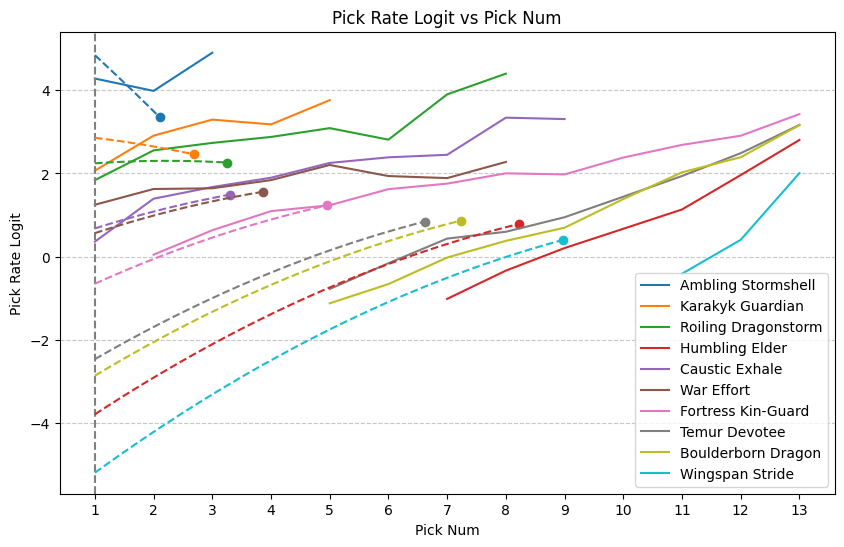

In [217]:
def model_curve(x, s, t):
    z = s - x
    return t + (t-1.54) * z / (s - 1) - 0.24 * z - 0.04 * z ** 2
    
sample_df = stat_df.filter(pl.col('name').is_in(names) & (pl.col('expansion') == 'TDM'))

ax = line_plot(df, title="Pick Rate Logit vs Pick Num", y_label="Pick Rate Logit", return_ax=True)
ax.axvline(x=1, color="grey", linestyle="--")
for name in names:
    row = sample_df.filter(pl.col('name') == name)[0]
    s = row['alsa'][0]
    t = row['pick_rate_logit_seen'][0]
    ax.scatter(s, t)
    x = np.arange(1, s, 0.01)

    ax.plot(x, model_curve(x, s, t), linestyle="--")
    
plt.show()

That looks as good as I could have hoped for. Let's finish by revisiting the substitution analysis with our new NPR metric along with our MLE solution. I expect to perform nearly as well as SD.

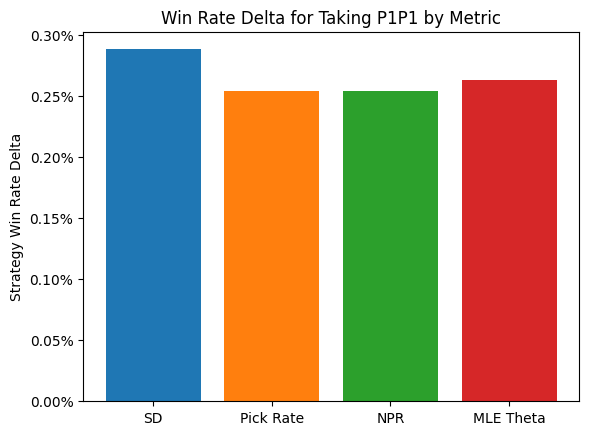

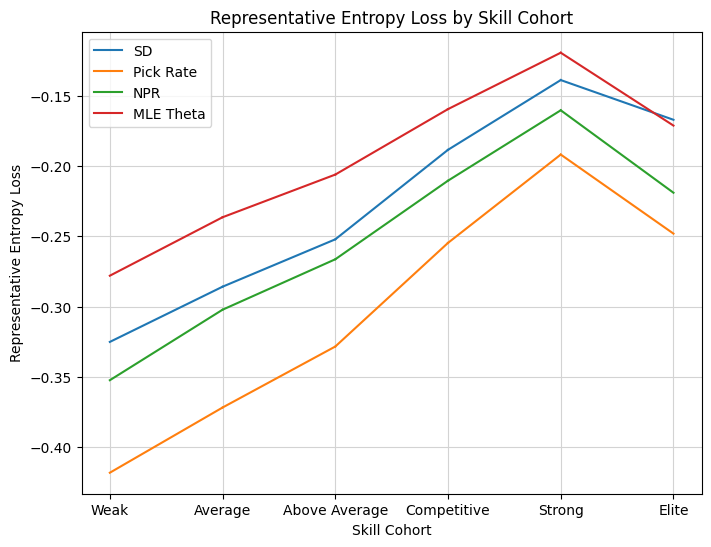

In [222]:
ext = {
    **ext,
    'npr': agg_col(2 * pl.col('pick_rate_logit_seen') - 0.16 * pl.col('alsa') - 0.04 * pl.col('alsa').pow(2))
}
labels = {**labels, 'npr': 'NPR', 'theta': 'MLE Theta'}
metrics = ['danb', 'pick_rate', 'npr', 'theta']
metric_context = metric_context.join(theta_df, on=['name', 'expansion'])

result = all_metrics_analysis(
    sets=sets,
    metrics=metrics, 
    results_filter=results_filter,
    metric_filter=metric_filter,
    metric_context=metric_context,
    extra_ext=ext
)

p1_delta_bar(result, metrics=metrics, metric_labels=labels)
p1_line_plot(result, mode="entropy_loss", metrics=metrics,  metric_labels=labels)

We could have hoped for better performance compared to Pick Rate, but it is certainly the case the the model better captures preferences than the pick rate data alone, so hopefully the community will find it useful. The MLE solution also did a great job of capturing that top player preference, the highest I've seen from any metric yet. That's all for now, drop by in a few weeks for a deep dive into data drafting the new powered cube!